# Dano's CORVO & TPOT  notebook

In this notebook, I will try and use TPOT to asses what traditional ML algorithms would be useful to predict cognitive performance from EEG data in Neurodoro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
from math import sqrt
import pyriemann


In [2]:
EPOCH_LENGTH = 440 # 2 seconds

In [21]:
# Data has been collected, let's import it

data = pd.read_csv("../muse-data/MonicaGRawEEG0.csv", header=0, index_col=False)

data

,Timestamp (ms),Difficulty,Performance,Channel 1,Channel 2,Channel 3,Channel 4
0,1496428421495,0,0,487.232990,569.475538,575.156767,479.387484
1,1496428421495,0,0,456.075779,522.673674,514.112317,409.617701
2,1496428421496,0,0,835.957052,962.667141,952.051364,778.598121
3,1496428421496,0,0,912.851281,1057.227213,1054.159345,870.660624
4,1496428421496,0,0,706.852916,802.325481,789.910665,659.249648
5,1496428421496,0,0,617.613835,711.468400,711.485316,585.479840
6,1496428421496,0,0,717.877179,818.589342,829.912818,704.245968
7,1496428421497,0,0,776.271770,870.050917,878.268466,749.776457
8,1496428421497,0,0,759.758949,852.210667,866.282786,709.933029
9,1496428421497,0,0,775.530536,856.145420,876.778855,761.307720


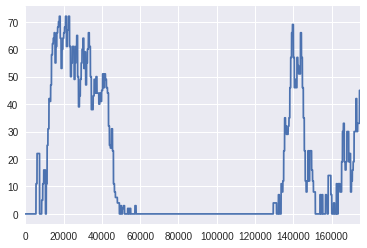

In [22]:
%matplotlib inline
data.Difficulty.plot()

In [5]:

from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt


sfreq = 256

# name of each channels 
ch_names = ['Perf', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values[:,-5:].T

# convert in Volts (from uVolts)
data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=5, n_times=175020
    Range : 0 ... 175019 =      0.000 ...   683.668 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-6-f5fb5df93d8b>:1: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


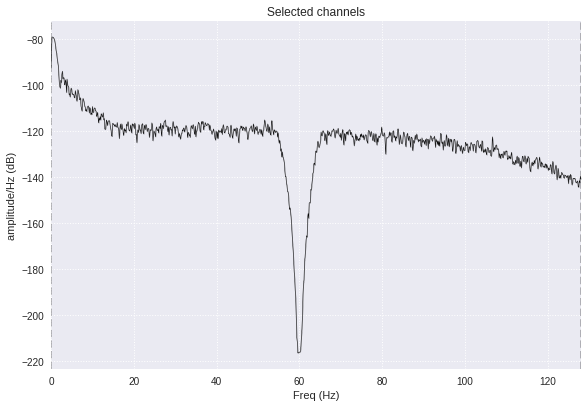

In [6]:
raw.plot_psd(picks=[1]);

In [7]:
raw.filter(8, 15, method='iir')

Setting up band-pass filter from 8 - 15 Hz


<RawArray  |  None, n_channels x n_times : 5 x 175020 (683.7 sec), ~6.7 MB, data loaded>

## Epochs

In [25]:
event[300]

array([38400,     0,     1])

In [42]:
from mne import make_fixed_length_events, Epochs

event = make_fixed_length_events(raw, 1, duration=0.5)

epochs = Epochs(raw, event[20:300], tmin=0, tmax=5, preload=True)

epochs

280 matching events found
0 projection items activated
Loading data for 280 events and 1281 original time points ...
0 bad epochs dropped


<Epochs  |  n_events : 280 (all good), tmin : 0.0 (s), tmax : 5.0 (s), baseline : (None, 0), ~13.7 MB, data loaded>

In [43]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(280, 4, 1281) (280, 1)


In [44]:
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LinearRegression

clf = make_pipeline(Covariances(estimator='lwf'), TangentSpace(), LinearRegression())

clf.fit(X, y)

Pipeline(steps=[('covariances', Covariances(estimator='lwf')), ('tangentspace', TangentSpace(metric='riemann', tsupdate=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

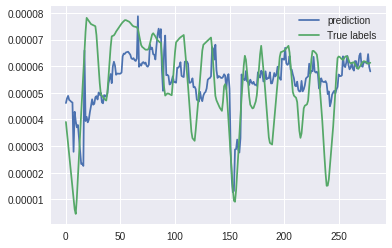

In [45]:
pr = clf.predict(X)
plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

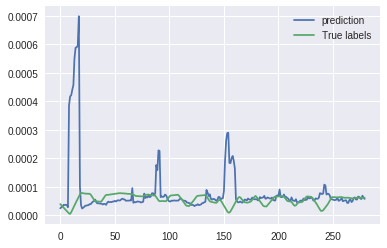

In [47]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=2)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

In [5]:
# Let's get our labels data set first because it's easier. We'll grab every 4th row from the Performance column

labels = data['Performance'].iloc[::4]

# Then we'll reindex the dataframe

labels = labels.reset_index().drop('index', axis=1)

# Convert to 1D array for TPOT

labels = np.array(labels).ravel()


In [6]:
# Seperate data into 4 dataframes, 1 for each electrode

chan1 = data.loc[:,'Channel':'60 hz'].loc[data['Channel'] == 1,].reset_index(drop=True)
chan1.columns = np.arange(1000,1061)
chan2 = data.loc[:,'Channel':'60 hz'].loc[data['Channel'] == 2,].reset_index(drop=True)
chan2.columns = np.arange(2000,2061)
chan3 = data.loc[:,'Channel':'60 hz'].loc[data['Channel'] == 3,].reset_index(drop=True)
chan3.columns = np.arange(3000,3061)
chan4 = data.loc[:,'Channel':'60 hz'].loc[data['Channel'] == 4,].reset_index(drop=True)
chan4.columns = np.arange(4000,4061)


# Concat all channel-specific dataframes together so that row = 2s epoch
# columns = [electrode 1 FFT bins] + [electrode 2 FFT bins] + ...
training_data = pd.concat([chan1.iloc[:,1:], chan2.iloc[:,1:], chan3.iloc[:,1:], chan4.iloc[:,1:]], axis=1, join_axes=[chan1.index])

In [7]:
print(training_data.shape)
labels.shape


(338, 240)


(338,)

# Nice!

In [8]:
# Create a TPOTClassifier that will run for 10 generations

pipeline_optimizer = TPOTRegressor(generations=10, population_size=30, cv=5,
                                    random_state=42, verbosity=3) 

# Fit this baby! Takes a long time to run

pipeline_optimizer.fit(training_data, labels)  
  
# See what kind of score we get
print(pipeline_optimizer.score(training_data, labels))

/home/dano/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


28 operators have been imported by TPOT.
_pre_test decorator: _generate: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _generate: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _generate: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _generate: num_test=1 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _generate: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _generate: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:   0%|          | 0/330 [00:00<?, ?pipeline/s]

_pre_test decorator: _generate: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _generate: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _generate: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:   9%|▉         | 30/330 [04:15<29:48,  5.96s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 72
_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 72
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=3 b'[16:11:16] src/tree/updater_colmaker.cc:161: Check failed: (n) > (0) colsample_bytree=1 is too small that no feature can be included'


Optimization Progress:   9%|▉         | 31/330 [04:16<27:17,  5.48s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  18%|█▊        | 59/330 [06:17<18:20,  4.06s/pipeline]

Generation 1 - Current Pareto front scores:
1	406.2644278849401	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=65, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	398.90744129335917	KNeighborsRegressor(MaxAbsScaler(input_matrix), KNeighborsRegressor__n_neighbors=65, KNeighborsRegressor__p=1, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  18%|█▊        | 59/330 [06:23<18:20,  4.06s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  20%|█▉        | 65/330 [06:31<17:16,  3.91s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  27%|██▋       | 89/330 [08:05<17:19,  4.31s/pipeline]

Generation 2 - Current Pareto front scores:
1	406.2644278849401	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=65, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	396.70984202431094	RandomForestRegressor(Normalizer(input_matrix, Normalizer__norm=DEFAULT), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=14, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65
_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65
_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65
_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,

Optimization Progress:  27%|██▋       | 89/330 [08:06<17:19,  4.31s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  27%|██▋       | 89/330 [08:06<17:19,  4.31s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  28%|██▊       | 92/330 [08:11<14:35,  3.68s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=2 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=3 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=4 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=5 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=6 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=7 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=8 __ini

Optimization Progress:  36%|███▌      | 118/330 [09:35<11:59,  3.39s/pipeline]

Generation 3 - Current Pareto front scores:
1	406.2644278849401	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=65, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  36%|███▌      | 118/330 [09:36<11:59,  3.39s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=2 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=3 __init__() got an unexpected keyword argument 'max_depth'


          on Progress:  36%|███▌      | 119/330 [09:37<08:41,  2.47s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_mutation_operator: num_test=1 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_mutation_operator: num_test=2 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_mutation_operator: num_test=3 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_mutation_operator: num_test=4 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid

Optimization Progress:  45%|████▍     | 148/330 [10:05<03:54,  1.29s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 4 - Current Pareto front scores:
1	406.2644278849401	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=65, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  45%|████▍     | 148/330 [10:05<03:54,  1.29s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=2 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=3 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=4 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=5 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=6 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=7 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=8 __ini

Optimization Progress:  47%|████▋     | 154/330 [10:06<02:50,  1.03pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  53%|█████▎    | 176/330 [11:11<04:28,  1.74s/pipeline]

Generation 5 - Current Pareto front scores:
1	405.63061664041146	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=83, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=distance)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  55%|█████▍    | 181/330 [11:12<03:48,  1.53s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  56%|█████▌    | 184/330 [29:16<2:14:32, 55.29s/pipeline]

Skipped pipeline #184 due to time out. Continuing to the next pipeline.


Optimization Progress:  61%|██████    | 200/330 [29:22<29:12, 13.48s/pipeline]  

Generation 6 - Current Pareto front scores:
1	405.4596058814028	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=81, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  61%|██████    | 200/330 [29:22<29:12, 13.48s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  61%|██████    | 200/330 [29:22<29:12, 13.48s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=2 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=3 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=4 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=5 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=6 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=7 __init__() got an unexpected keyword argument 'max_depth'
_pre_test decorator: _random_mutation_operator: num_test=8 __ini

Optimization Progress:  62%|██████▏   | 206/330 [29:23<20:05,  9.72s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 95
_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 95
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated durin

Optimization Progress:  70%|██████▉   | 230/330 [30:12<04:16,  2.57s/pipeline]

Generation 7 - Current Pareto front scores:
1	405.4596058814028	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=81, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  73%|███████▎  | 240/330 [30:12<02:44,  1.83s/pipeline]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated

Optimization Progress:  80%|███████▉  | 263/330 [30:24<00:46,  1.44pipeline/s]

Generation 8 - Current Pareto front scores:
1	405.4596058814028	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=81, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: nu

Optimization Progress:  85%|████████▌ | 282/330 [30:26<00:08,  5.77pipeline/s]

Generation 9 - Current Pareto front scores:
1	402.8218201267898	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=73, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=uniform)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)



Optimization Progress:  87%|████████▋ | 286/330 [30:26<00:07,  5.83pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dua

Generation 10 - Current Pareto front scores:
1	402.8218201267898	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=73, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=uniform)
2	375.3292896161379	KNeighborsRegressor(Normalizer(input_matrix, Normalizer__norm=l1), KNeighborsRegressor__n_neighbors=26, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=DEFAULT)

299.158905501


In [9]:
pipeline_optimizer.export('tpot_exported_pipeline4.py')

In [21]:
print(sqrt(pipeline_optimizer.score(training_data, labels)))

17.296210726644947


##### Split values and labels arrays into random train and test subsets (20% set aside for testing)
X_train, X_test, y_train, y_test = train_test_split(training_data,labels,test_size=0.2)

In [22]:
print(sqrt(98))

9.899494936611665
